코드를 돌리기 위해서는 colab 을 사용할 것을 권장합니다. 

이유는 JAX/FLAX의 사용이 TPU를 사용할 수 있다는 것에 장점이 있기 때문입니다. 

기본적으로, JAX/FLAX 는 구글에서 개발한 라이브러리입니다. 구글에서는 라이브러리 외에도 하드웨어 역시 개발하고 있는데, GPU를 대체하기 위해서 개발한 인공지능 가속기가 TPU입니다. 

## TPU(Tensor Processing Unit)

1) GPU가 RAM-VRAM-GPU의 단계를 거쳐서 데이터를 불러오고 연산하는 반면, TPU는 고성능 RAM에 바로 연결되어 연산을 할 수 있다는 장점이 있습니다. 

2) 병렬 처리의 간편함 (pmap) 때문에 TPU는 보통 여러 개의 코어(Core)가 묶여 있는 형태로 구성되어 병렬 연산의 성능이 뛰어나고 귀찮은 GPU-CPU사이의 통신들을 신경을 훨씬 덜 써도 됩니다. 

결과적으로 대규모 모델 학습의 효율성때문에 쓰입니다. 최근의 거대 언어 모델(LLM)들은 하나의 GPU 메모리에 다 들어가지 않는 문제를 해결하기 위해서 등장했다.. 고 봐도 무방합니다만 원래는 알파고 같은 모델에서 병렬연산을 하는데 쓰이기도 했습니다.

# JAX/FLAX

제가 왜 자꾸 JAX랑 FLAX를 묶어서 부를까요? 이는 JAX와 FLAX 의 역할이 다르기 때문에 둘을 함께 써야지만 torch처럼 신경망을 만들고 학습하는 전체 과정을 만들수 있기 때문입니다.

## JAX

**특징 1. numpy와 유사하게 구현된 라이브러리**

JAX는 간단하게 말하자면 numpy 와 유사합니다. 조금 더 정확히는 하드웨어에서 가속해서 돌릴 수 있도록 만들어진 numpy 라이브러리라고 보셔도 됩니다. python의 태생적인 한계 (인터프리터 언어)를 벗어나서 C++이나 Java의 방식처럼 컴팡리해서 돌리는 등의 가속을 지원합니다. 

**특징 2. torch 와 유사하게 구현된 autograd**

torch 가 맨 처음 나왔을때는 autograd라는 기능 때문에 이전에 tensorflow가 주류였던 deep learning 커뮤니티를 단 시간에 휘어잡았습니다. 이 autograd 라는 기능은 우리가 작성한 수치 연산 코드를 역추적하여, 복잡한 미분 공식을 직접 손으로 풀거나 구현할 필요 없이 '기울기(Gradient)'를 자동으로 계산해 주는 기능입니다 (callback 함수가 기본으로 달려서 파라미터들이 알아서 추적되고 backward 한번에 자동으로 계산되도록)

JAX는 jax.grad라는 함수를 통해 이를 수학적으로 매우 깔끔하고 효율적으로 처리합니다. 심지어 딥러닝만을 위한 라이브러리가 아니라 수학적으로 쓰기에도 아주 좋은데, backward 미분만을 지원하는게 아니라 forward 미분을 지원합니다. 

심지어 심지어 미분한 함수를 또 미분하는 것도 가능합니다. 두 번 이상 미분하는 쓰는 경우가 있죠. 우리 수업에서 Optimal Brain Damage 또는 Optimal Brain Surgery 를 다룬적이 있었는데요, 이때 2계도 미분을 사용했었습니다. 한 번 미분한 값은 기울기를 나타내고, 2계도 미분은 변곡점을 측정하는 역할읋 합니다. 중요한 파라미터라면 2계도함수 값이 크고 (변곡률이 커서 어디 minima겠구나) 업데이트해도 변곡률이 없는 그냥 이상한 평평한 tail에 해당하면 지운다~ 이런 느낌일때 씁니다.

**특징 3. XLA (가속 선형 대수) 컴파일러 - JIT 컴파일 지원**

파이썬은 인터프리터언어라서 그 라인을 실행하는 순간 컴파일하고 코드를 실행하는 방식으로 진행됩니다. 근데 C++, JAVA같은 좀 전통적인 언어들은 컴파일을 하고 컴파일된 파일이 있다면 바로 execute 가 가능하기 때문에 빠르게 실행이 됩니다.

이 부분이 JAX가 TPU에서 쓰기 좋은 이유이기도 합니다. JAX는 파이썬 코드를 읽어서 XLA라는 컴파일러에게 넘깁니다. XLA는 코드를 분석해서 GPU나 TPU가 가장 빠르게 처리할 수 있는 기계어 형태로 최적화(퓨전 등)하여 실행합니다. 덕분에 같은 연산도 일반 NumPy보다 훨씬 빠르게 수행됩니다. numpy 는 그냥 C++ 코드 중 몇개를 라이브러리 내에 사전 컴파일 해놓는거고, JAX는 파이썬 코드로 (jax 의 문법을 써서) 자기가 원하는대로 만들고 그걸 컴파일 해놓을 수 있다는 장점이 있습니다. 이게 TPU같은 디바이스가 다양하더라도 잘 써먹을 수 있는 이유입니다. 


## FLAX

그럼 FLAX 는 뭘까요? JAX가 XLA를 위한 numpy 같이 생긴 라이브러리라면, FLAX는 그 위에서 딥러닝을 구현하기 위한 부분만 구성한 라이브러리라고 생각하시면됩니다. 즉 신경망 층(Layer)을 쌓고 관리하는 역할입니다.

torch는 그 두개가 합쳐져 있기 때문에 numpy 연산을 torch.tensor를 통해서 수행하고 torch.nn 모듈이 신경망을 만들고 관리합니다만 JAX/FLAX는 그렇게 구분되어있습니다. 왜냐고요? JAX 개발한 팀이랑 FLAX 개발한 팀이 다른 팀이라 별개로 개발되어서 그렇댑니다.

**특징 1. JAX 기반의 Neural Network 라이브러리**

앞서 말씀드린것처럼 JAX만으로는 Linear, Conv2d 같은 딥러닝 레이어를 구현하기 위해 매번 행렬 곱셈 식을 직접 짜야 합니다. FLAX는 이를 미리 모듈화해 두었습니다. 혹시 numpy 로 신경망 만들기 해보셨나요? 싫죠? 그렇습니다. 
- FLAX는 PyTorch의 torch.nn 모듈과 같은 역할을 합니다.
- 복잡한 ResNet, Transformer 같은 모델도 FLAX를 쓰면 블록 쌓듯이 쉽게 조립할 수 있게 만들어져 있습니다.

**특징 2. 파라미터(가중치)의 명시적 관리**

PyTorch나 Keras와 또 다른 점입니다. 보통의 프레임워크는 model이라는 객체 안에 가중치(W, b)가 숨어 있어서 알아서 관리됩니다. 하지만 FLAX는 JAX의 특성상 **함수가 파라미터를 포함한 데이터를 저장하지 않게 (stateless)** 구성됩니다.

- PyTorch: model(input) → 모델 안에 저장된 가중치를 사용하여 결과 출력
- FLAX: model(params, input) → 이 가중치(params)를 사용해서 이 입력(input)을 처리하라고 매번 명시적으로 넣어줘야 함.

처음엔 번거로워 보이지만, 이 방식 덕분에 **TPU의 여러 코어에 가중치를 복사하거나 쪼개서 보내는 병렬 처리(Parallelism)** 가 훨씬 투명하고 오류 없이 작동합니다

## 그 외에

그 외에도 JAX는 이런 추가 라이브러리를 몇 개씩 더 설치해서 사용하고는 합니다. nn.module 에 대응되는것이 flax였다면, optimizer 에 대응되는 것은 optax이고... 그런 식 입니다. 

그리고 코드를 짜는 구조는 기본적으로 torch 의 방식을 따르지만 몇가지 다른점이 있습니다. 그 점만 잘 이해하면 솔직히 아주 어렵진 않습니다.

이제 직접 하나씩 봅시다!!

# 함수형 프로그래밍

엣날 옛적에... tensorflow 가 0.X 버전이던 시절에는 코딩을 함수형 프로그래밍으로만 지원했습니다. 함수형 프로그래밍(functional programming)은 계산이 수학적 함수 단위로 처리되는 것을 의미합니다. 

간단하게 설명하자면, 컴파일되어서 입력값을 넣어주면 그 입력값만을 변수로 갖고 연산해서 결과를 출력하는 함수들로 프로그래밍을 합니다.

 함수형이 아닌 프로그래밍 방식, 일반적인 절차지향형 프로그래밍에서는 외부변수를 활용하거나 전역변수를 활용하거나, 함수에 동적인 입력값이 있어 어떤 값이 변경되면 값이 변경됨에 따라 연산 결과나 절차가 달라지도록 프로그래밍 되어있습니다. 아주 간단한 예시를 들면 다음과 같습니다.
```python
b = 10
def return_greater(a):
    if a > b:
        return a
    else:
        return b
```

위와 같은 코드는 간단하게 a랑 b중 큰 것을 리턴하도록 되어있습니다. 이때 함수에 들어오는 입력값은 a밖에 없고 b는 외부에서 들어오는 값입니다. 그러면 return_greater 라는 함수를 컴파일 했을때 우리는 입력값으로 a만 넣어줄수 있고 b에 대해서는 알수가 없습니다. 이 경우는 함수형 프로그래밍이 아닙니다.

반면 아래는 함수형 프로그래밍입니다.

```python
def return_greater(a,b):
    if a > b:
        return a
    else:
        return b
```

입력값을 둘로 넣어주긴 했지만 암튼 컴파일했을때 두 입력값이 주어지면 외부에서 변수를 받지 않고도 연산이 됩니다. 이런식으로 외부와 단절되어있는형태이긴 하지만, 그렇기 때문에 python으로 작성되었음에도 컴파일해서 빠르게 돌릴 수 있게 만들 수 있습니다. 

이런걸 **순수 함수**라고 합니다. 

## 순수 함수

순수 함수는 부수효과(side effect)가 없고 불변성(immutability)을 가질때 함수를 순수함수라고 합니다. 여기서 얘기하는 부수효과가 함수 외부에 영향을 끼치거나 받는, 외부의 변수와 상호작용 하는걸 의미합니다 (예: 전역변수의 변경, 전역변수에 따른 함수). 예를 들어 아래함수는 전역변수를 변경시키고 그 변수가 계속 함수내에서 연산에 쓰입니다.


In [ ]:
counter = 0

def increment_counter(x):
  global counter
  counter += x
  return counter


print(increment_counter(1))
print(increment_counter(2))
print(increment_counter(3))
print('after_counter:', counter)

이때 부수효과를 제거하면 다음과 같습니다. 전역변수를 변경시키지 않습니다.

In [1]:
def not_side_effect_example(counter, x):
    return counter + x

counter = 0

for a in range(3):
    print(not_side_effect_example(counter,a+1))

print('after_counter:', counter)

1
2
3
after_counter: 0


불변성이란 것은 한번 생성된 데이터가 변경되지 않는 것을 의미합니다. 다시말해 변수에 값을 할당하면 변하지 않고 쭉 유지되는걸 의미합니다. 예를 들어 아래와 같은 함수는 부수효과가 없고 불변성이 없는 함수입니다. 

In [2]:
def create_counter():
    count = [0]
    def counter():
        count[0] += 1
        return count[0]
    return counter

counter = create_counter()
print(counter())  # 1
print(counter())  # 2
print(counter())  # 3
print(counter())  # 4
print(counter())  # 5

1
2
3
4
5


부수효과는 없지만 불변성도 없기 때문에 여기서 불변성을 가진다면 다음과 같습니다 

In [ ]:
counter = 0
def immutable_example(state,x):
    counter = state
    return counter + x

for a in range(3):
    print(immutable_example(0,a+1))
    print('counter:', counter)

## 들어가기 전에...

더 자세히 들어가기전에 파이썬에 대해 알아야하는 것이 있습니다. 

### 데코레이터와 partial()

JAX는 데코레이터와 functools.partial() 라이브러리를 많이 사용합니다.

데코레이터는 파이썬에서 어떤 함수를 선언할때 데코레이터로 선언한 함수로 감싸서 포장해주는, 꾸며주는 것을 간단하게 선언하는 걸 의미합니다. 아래와 같은 함수를 봅시다. 

In [3]:
def my_decorator(func):
    # 1. 래퍼(Wrapper) 함수를 정의합니다.
    def wrapper():
        print("--- 함수 실행 전: 준비 운동 ---")
        func()  # 2. 여기서 원래 함수를 실행합니다.
        print("--- 함수 실행 후: 정리 운동 ---")
    
    return wrapper  # 3. 래퍼 함수 자체를 반환합니다.

# 데코레이터 적용하기 (@ 기호 사용)
@my_decorator
def say_hello():
    print("안녕하세요!")

# 실행
say_hello()

--- 함수 실행 전: 준비 운동 ---
안녕하세요!
--- 함수 실행 후: 정리 운동 ---


위와 같이 @my_decorator 가 함수를 wrapper 의 형태로 불러오는 걸 볼 수 있습니다.

보시면 아시다시피 데코레이터의 사용은 다음과 완전히 동일합니다.

`say_hello = my_decorator(say_hello)`

functools.partial() 은 파이썬의 기본 라이브러리인 functools에 구현된 메서드중 하나를 의미하는 것으로, 파이썬으로 선언된 함수를 '함수형'으로 여러번 반복호출하는데 도움이 됩니다. 

functools.partial() 은 기존함수에서 일부 입력값을 '고정'하고 남은 입력값을 실제 입력값으로 갖는 새로운 함수를 정의하기 위해서 쓰입니다. 예를 들면 다음과 같습니다. 

In [ ]:
def add_mul(x, y, z):
    return x + y * z

print('not_using_partial :', add_mul(2, 3, 1))
print('not_using_partial :', add_mul(3, 4, 1))
print('not_using_partial :', add_mul(6, 8, 1))

#partial을 사용한 예시
from functools import partial

add_2 = partial(add_mul, z = 1)

print('using_partial :', add_2(2, 3))
print('using_partial :', add_2(3, 4))
print('using_partial :', add_2(6, 8))

보시다시피 add_2로 새롭게 선언된 함수는 z값이 고정되고 입력값을 2개만 받는 형태로 변경되었습니다. 

JAX에서는 순수함수가 아닌 형태로 정의된 함수가 있을때 이를 순수함수의 형태로 바꾸기 위해서 몇몇 입력값을 고정해버리는 역할을 합니다. 그 외에도 그렇게 고정한 변수가 사실 전역변수라 변경되어야한다면 리컴파일 해야하는데... 그런 걸 시킬 때도 사용합니다. 나중에 jax 문법에 익숙해지면 더 자세히 이해할 수 있겠지만 일단 어떻게 쓰는지 봅시다.

```python
import jax
import jax.numpy as jnp
from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g(x, n):
    for i in range(n):
        x = x ** 2
    return x

g(jnp.arange(4), 3)
```

여기서 주의할점은 원래 partial은 데코레이터로 쓸수 없는 함수인데 (위위 예시 참조) jax에서는 데코레이터로 사용할 수 있게 되었다는 점 입니다. 

### colab에서 TPU쓰기

TPU는 google cloud platform 에서만 쓸 수 있습니다 (하드웨어를 안팝니다) 그래서 colab, GCP에서만 실습할 수 있습니다. 런타임>런타임유형변경>TPU를 고릅니다. 근데 GCP가 아니면 TPU를 여러갤 쓸수 없어요. 그래서 쓸 이유가 없습니다.

### JAX FLAX 설치하기

In [6]:
!pip install jax
# !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install "jax[cpu]"
!pip install flax

# JAX 는 numpy 다

JAX의 1차적목표는 **GPU를 사용할수 있고 컴파일이 가능한 형태의 선형대수 연산을 만드는 것** 입니다. 그 과정에서 사람들이 편하게 구현할 수 있게 하기 위해서 numpy 처럼 코딩해서 연산을 표현할 수 있도록 지원합니다. 

In [7]:
import jax
import jax.numpy as jnp
import numpy as np
from IPython.display import display

x = np.array([1.0, 2.0, 3.0, 4.0])
y = np.array([5.0, 6.0, 7.0, 8.0])
z = x + y

display(z)  # 출력: array([6., 8., 10., 12.])

array([ 6.,  8., 10., 12.])

이걸 jax 로 표현하면 다음과 같이 됩니다. 

In [8]:
x = jnp.array([1.0, 2.0, 3.0, 4.0])
y = jnp.array([5.0, 6.0, 7.0, 8.0])
z = x + y
display(z)  # 출력: Array([6., 8., 10., 12.], dtype=float32)


Array([ 6.,  8., 10., 12.], dtype=float32)

autograd는 다음과 같은 방식으로 계산합니다. 그냥 단순하게 함수를 미분하는 방식으로 그냥 수학 처럼 쓰면 됩니다

In [9]:
def f(x):
    return x ** 2

df = jax.grad(f)

display(df(2.0))  # 출력: Array(4., dtype=float32)

Array(4., dtype=float32, weak_type=True)

아주 쉽죠? 이런식으로 수학을 GPU/TPU로 빠르게 연산하는게 목적입니다.

손실함수를 정의하고 이에 대해서 계산하는 것도 다음과 같이 하면 됩니다. 

In [ ]:
def mse_loss(y_true, y_pred):
    return jnp.mean((y_true - y_pred) ** 2)

# 임의의 예측값과 실제값
y_true = jnp.array([1.0, 2.0, 3.0])
y_pred = jnp.array([1.5, 1.5, 3.5])

# 손실함수의 그래디언트를 계산하기 위한 함수 정의
grad_mse_loss = jax.grad(mse_loss, argnums=1)

# 그래디언트 계산
gradient = grad_mse_loss(y_true, y_pred)

display(gradient)  # 출력: Array([ 0.33333334, -0.33333334,  0.33333334], dtype=float32)


여기서 argnums 는 몇번째 인자에대해서 편미분하는지를 의미합니다. 즉 어떤 인자를 기준으로 그래디언트를 계산하는지를 지정합니다.

손실함수의 중간과정을 보고싶으면 어떻게 할까요? mse_loss 함수내에서 print를 쓰면 될까요? 돌아는 가는데, 컴파일을 할 수 없는 형태입니다. 왜? print는 생긴건 저래도 함수형이 아닙니다. 외부와 상호작용하는 것의 대표가 print 입니다. 되도록 쓰지 맙시다.

그럼 어떻게 할까요? jax에는 value_and_grad 라는 메서드가 정의되어 있어 함수의 리턴값(여기는 loss) 그리고 gradient를 동시에 리턴하도록 만들 수 있습니다.

In [12]:
def mse_loss(y_true, y_pred):
    return jnp.mean((y_true - y_pred) ** 2)

# 임의의 예측값과 실제값
y_true = jnp.array([1.0, 2.0, 3.0])
y_pred = jnp.array([1.5, 1.5, 3.5])

# 손실함수와 그래디언트를 동시에 계산하기 위한 함수 정의
value_and_grad_mse_loss = jax.value_and_grad(mse_loss, argnums=1)

# 손실값과 그래디언트 동시에 계산
loss_value, gradient = value_and_grad_mse_loss(y_true, y_pred)

display('Loss Value:', loss_value)  # 출력: Loss Value: 0.25
display('Gradient:', gradient)  # 출력: Gradient: Array([ 0.33333334, -0.33333334,  0.33333334], dtype=float32)

'Loss Value:'

Array(0.25, dtype=float32)

'Gradient:'

Array([ 0.33333334, -0.33333334,  0.33333334], dtype=float32)

다음과 같이 하면 어떻게될까요? 

In [13]:
def mse_with_aux(pred, target):
    error = pred - target
    mse = np.mean(error ** 2)
    return mse, error  # MSE 결과와 보조 결과인 에러를 반환

# 가정된 예측값과 타겟값
pred = np.array([1.0, 2.0, 3.0])
target = np.array([1.5, 2.5, 3.5])

grad_fun, aux = jax.grad(mse_with_aux)(pred, target) # TypeError 발생

TypeError: Gradient only defined for scalar-output functions. Output was (Array(0.25, dtype=float32), Array([-0.5, -0.5, -0.5], dtype=float32)).

왜 에러가 날까요? jax.grad함수는 기본적으로 스칼라 값 하나에 대해서만 작동합니다. 즉 리턴값이 1개인 함수에 대한 미분만을 지원합니다. 

이럴땐 argnums를 설정했듯이 has_aux = True 를 설정해주면 됩니다.

In [15]:
grad_fun, aux = jax.grad(mse_with_aux, has_aux=True)(pred, target) # 정상적으로 동작

print(grad_fun)
print(aux)

[-0.33333334 -0.33333334 -0.33333334]
[-0.5 -0.5 -0.5]


고계도 함수를 계산하는 것도 가능하다고 했죠?

In [16]:
def f(x):
    return x ** 2

df = jax.grad(f)
d2f = jax.grad(df) # jax.grad(jax.grad(f)) 와 같다

display(df(2.0))  # 출력: Array(4., dtype=float32)
display(d2f(2.0))  # 출력: Array(2., dtype=float32)



Array(4., dtype=float32, weak_type=True)

Array(2., dtype=float32, weak_type=True)

# JAX 로 간단한 선형회귀 해보기

다음과 같은 선형회귀를 해봅시다. 

$y = wx + b + \epsilon$

대충 원래는 이렇게 하죠?

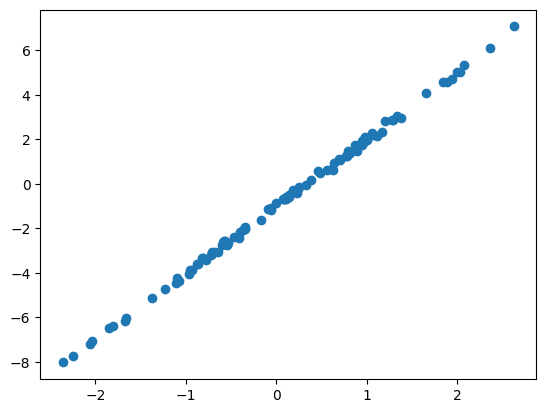

In [19]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

모델을 선언하고 loss 를 만들어서 예측하도록 만들어야합니다. 모델을 만들때 jax를 쓰려면 순수함수로 만들어야합니다. 

In [22]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

In [23]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [24]:
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.00, b: -0.99


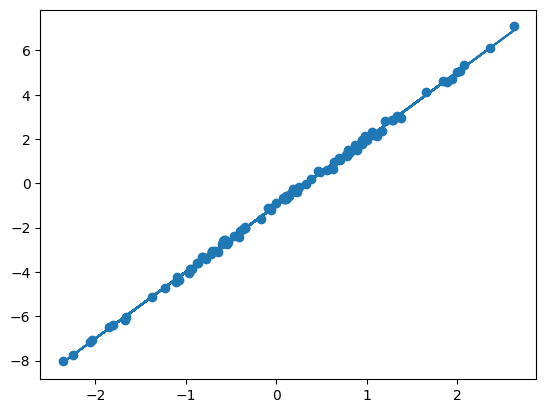

In [25]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")  # 출력: w: 3.00, b: -1.00

